# Test the models

### 1. Load Data (All Label)

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import tensorflow as tf
import xgboost

#import matplotlib.pyplot as plt
#import seaborn as sns
#from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
#from tqdm import tqdm
#from torch.optim import AdamW
#from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Set TensorFlow logging level to suppress unnecessary output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [3]:
# Helper function: Load embeddings from TFRecord files
def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        embedding_feature = example.features.feature['embedding']
        embedding_values = embedding_feature.float_list.value
    embedding = torch.tensor(embedding_values)
    if torch.isnan(embedding).any() or torch.isinf(embedding).any():
        raise ValueError(f"NaN or Inf found in embedding: {embedding_path}")
    return embedding

In [4]:
# Custom dataset class for MIMIC chest X-ray embeddings
class MIMIC_Embed_Dataset(Dataset):
    pathologies = [
        "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
        "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
        "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
    ]

    def __init__(self, embedpath, csvpath, metacsvpath, views=["PA"], mode="train", seed=42, split_ratio=[0.5, 0.3, 0.2], unique_patients=True):
        super().__init__()
        np.random.seed(seed)  # Set seed for reproducibility
        self.pathologies = sorted(self.pathologies)
        self.mode = mode
        self.embedpath = embedpath
        self.csv = pd.read_csv(csvpath)
        self.metacsv = pd.read_csv(metacsvpath)
        self.split_ratio = split_ratio

        # Merge CSV data
        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.csv = self.csv.join(self.metacsv).reset_index()

        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        # Split dataset into train, validation, and test sets
        n_row = self.csv.shape[0]
        if self.mode == "train":
            self.csv = self.csv[:int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[int(n_row * self.split_ratio[0]):int(n_row * (self.split_ratio[0] + self.split_ratio[1]))]
        elif self.mode == "test":
            self.csv = self.csv[int(n_row * (self.split_ratio[0] + self.split_ratio[1])):]
        else:
            raise ValueError(f"mode must be one of [train, valid, test], got {self.mode}")

        # Process labels
        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
            labels.append(mask.values)
        self.labels = np.asarray(labels).T.astype(np.float32)
        self.labels[np.isnan(self.labels)] = 0  # Replace all NaN values with 0
        self.labels = np.where((self.labels != 0) & (self.labels != 1), 0, self.labels)

        self.csv = self.csv.reset_index(drop=True)
        self.pathologies = list(np.char.replace(self.pathologies, "Pleural Effusion", "Effusion"))
        self.csv["offset_day_int"] = self.csv["StudyDate"]
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def limit_to_selected_views(self, views):
        # Limit dataset to specified views
        if not isinstance(views, list):
            views = [views]
        if '*' in views:
            views = ["*"]
        self.views = views
        self.csv["view"] = self.csv["view"].fillna("UNKNOWN")
        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve a single sample from the dataset
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]
        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])
        embed_file = os.path.join(self.embedpath, f"p{subjectid[:2]}", f"p{subjectid}", f"s{studyid}", f"{dicom_id}.tfrecord")
        sample["embedding"] = load_embedding(embed_file)
        return sample

In [5]:
# Function to initialize datasets with given paths, seed, and split ratio
def initialize_mimic_datasets(embedpath, csvpath, metacsvpath, seed=42, split_ratio=[0.5, 0.3, 0.2]):
    """
    Initialize MIMIC chest X-ray datasets with specified paths, seed, and split ratio.
    
    Args:
        embedpath (str): Path to the embedding files
        csvpath (str): Path to the CheXpert CSV file
        metacsvpath (str): Path to the metadata CSV file
        seed (int): Random seed for reproducibility (default: 42)
        split_ratio (list): Train, validation, test split ratio (default: [0.5, 0.3, 0.2])
    
    Returns:
        tuple: (train_dataset, val_dataset, test_dataset)
    """
    train_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="train",
        seed=seed,
        split_ratio=split_ratio
    )
    val_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="valid",
        seed=seed,
        split_ratio=split_ratio
    )
    test_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="test",
        seed=seed,
        split_ratio=split_ratio
    )
    return train_dataset, val_dataset, test_dataset

In [6]:
# Data paths
embedpath = "C:/Users/idaul/Dropbox/1 Idauli/1 NUS PhD/0 2025 Sem 5/1 SPH6004 Advanced Statistical Learning/Assignments/Assignment 2/Data/sph6004/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
csvpath = "C:/Users/idaul/Dropbox/1 Idauli/1 NUS PhD/0 2025 Sem 5/1 SPH6004 Advanced Statistical Learning/Assignments/Assignment 2/Data/mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "C:/Users/idaul/Dropbox/1 Idauli/1 NUS PhD/0 2025 Sem 5/1 SPH6004 Advanced Statistical Learning/Assignments/Assignment 2/Data/mimic-cxr-2.0.0-metadata.csv"

workpath = "C:/Users/idaul/Dropbox/1 Idauli/1 NUS PhD/0 2025 Sem 5/1 SPH6004 Advanced Statistical Learning/Assignments/Assignment 2/Data/"

In [7]:
train_dataset, val_dataset, test_dataset = initialize_mimic_datasets(
    embedpath=embedpath,
    csvpath=csvpath,
    metacsvpath=metacsvpath,
    seed=42,
    split_ratio=[0.5, 0.3, 0.2]
)

In [8]:
test_dataset[1000]

{'idx': 1000,
 'lab': array([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 'embedding': tensor([-0.5893, -1.4492,  1.0979,  ..., -0.6514,  1.0990, -0.9476])}

#### Test dataset

In [9]:
X_test = np.stack([sample['embedding'].numpy() for sample in test_dataset])  # shape: [n_samples, embedding_dim]
y_test = np.stack([sample['lab'] for sample in test_dataset])               # shape: [n_samples, n_labels]

In [10]:
X_test[1000]

array([-0.58929574, -1.4492148 ,  1.097911  , ..., -0.65142685,
        1.0990394 , -0.94760346], dtype=float32)

In [11]:
y_test[1000]

array([1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

#### Load models

In [12]:
modelpath = "C:/Users/idaul/Dropbox/1 Idauli/1 NUS PhD/0 2025 Sem 5/1 SPH6004 Advanced Statistical Learning/Assignments/Assignment 2/Models/"

In [13]:
# Custom scorer for MultiOutputClassifier
def multi_label_log_loss(y_true, y_pred_proba):

    # Convert list of arrays into a single NumPy array (shape: n_samples x n_labels)
    y_pred_proba_arr = np.array([proba[:, 1] if proba.ndim == 2 else proba for proba in y_pred_proba])
    
    # Check dimensions
    if y_true.shape != y_pred_proba_arr.shape:
        y_pred_proba_arr=y_pred_proba_arr.T
        #raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred_proba_arr {y_pred_proba_arr.shape}")
    
    # Compute log loss for each label
    losses = []
    for i in range(y_true.shape[1]):
        loss = log_loss(y_true[:, i], y_pred_proba_arr[:, i])  # Compute log loss for label i
        #print(loss)
        losses.append(loss)
    return np.mean(losses)  # Return mean log loss across all labels

In [14]:
class OptimizedFCNN(nn.Module):
    def __init__(self, input_dim=1376, dropout_prob=0.3):
        super(OptimizedFCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.fc4 = nn.Linear(128, 13)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x


In [15]:
# Logistic regressions
lr_van = joblib.load(modelpath+"vanilla_logreg_model.pkl")
lr_l1 = joblib.load(modelpath+"l1_logreg_model.pkl")
lr_l2 = joblib.load(modelpath+"l2_logreg_model.pkl")
lr_el = joblib.load(modelpath+"elasticnet_logreg_model.pkl")

# SVM
svm = joblib.load(modelpath+"BestSVM_AllData.pkl")

# XGBoost
xgb = joblib.load(modelpath+"model_xgb_all_v2.pkl")

# Random Forest
rf = joblib.load(modelpath+"rf_model.pkl")

#FCN
fcn = OptimizedFCNN(input_dim=1376, dropout_prob=0.2)
fcn.load_state_dict(torch.load(modelpath+"model_FCN.pth", map_location=torch.device('cpu'), weights_only=True))

<All keys matched successfully>

In [16]:
print(lr_van)
print(rf)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=10000, n_jobs=-1,
                                                   penalty=None,
                                                   random_state=10))
MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=15,
                                                       n_estimators=200,
                                                       n_jobs=2,
                                                       random_state=42),
                      n_jobs=2)


In [17]:
xgb_best = xgb.best_estimator_
#print(xgb)
print(xgb_best)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                         

In [18]:
svm_best = svm.best_estimator_
print(svm)
print(svm_best)

RandomizedSearchCV(cv=5,
                   estimator=OneVsRestClassifier(estimator=SVC(random_state=42)),
                   n_iter=4,
                   param_distributions={'estimator__C': [0.01, 0.1, 1, 10],
                                        'estimator__kernel': ['poly', 'rbf']},
                   scoring=make_scorer(f1_score, response_method='predict', average=micro))
OneVsRestClassifier(estimator=SVC(C=10, kernel='poly', random_state=42))


In [19]:
# Get the predictions
# LR
y_pred_lrvan = lr_van.predict_proba(X_test)
y_pred_lrl1 = lr_l1.predict_proba(X_test)
y_pred_lrl2 = lr_l2.predict_proba(X_test)
y_pred_lrel = lr_el.predict_proba(X_test)

# XGBoost
y_pred_xgb = xgb_best.predict_proba(X_test)

# Random Forest
y_pred_rf = rf.predict_proba(X_test)

In [20]:
# Since SVM did not set probabilities to true, calculate it using decision functions
# SVM
y_dec_svm = svm_best.decision_function(X_test)

In [21]:
y_dec_svm

array([[-1.47091208, -1.43852905, -1.09943774, ..., -1.19773363,
        -1.44573323, -1.23302447],
       [-1.08156023, -0.93393568, -1.02468388, ..., -1.10057699,
        -1.13249275, -1.04507902],
       [-1.05989922, -1.25486747, -1.01911833, ..., -0.87071877,
        -1.09461745, -1.33814423],
       ...,
       [-0.99077727, -1.12212923, -1.13120983, ..., -1.10291772,
        -1.26381855, -1.02782322],
       [-0.96007604, -0.96531317, -1.28004896, ..., -0.82151037,
        -1.14657786, -1.51013566],
       [-1.41590525, -1.37447022, -1.10912229, ..., -1.18009222,
        -1.33173746, -1.35111178]])

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

In [28]:
#import sys
#np.set_printoptions(threshold=sys.maxsize)

In [30]:
#CHECKS
#np.unique(y_test.ravel())
#y_test.astype(int).ravel().shape
#np.array(y_pred_lrl1).shape
y_pred_lrvan[0]
#y_test.shape
#y_test[0]

#np.array(y_pred_xgb).shape
#np.array(y_pred_rf).shape
#y_dec_svm.shape

array([[9.96816784e-01, 3.18321564e-03],
       [9.72900255e-01, 2.70997451e-02],
       [9.54408887e-01, 4.55911127e-02],
       [9.96967519e-01, 3.03248127e-03],
       [9.76611513e-01, 2.33884874e-02],
       [7.15548609e-01, 2.84451391e-01],
       [9.97317873e-01, 2.68212683e-03],
       [9.96684270e-01, 3.31573014e-03],
       [9.90539472e-01, 9.46052787e-03],
       [9.95598403e-01, 4.40159742e-03],
       [9.51598611e-01, 4.84013891e-02],
       [9.95611632e-01, 4.38836842e-03],
       [9.32992369e-01, 6.70076312e-02],
       [9.99089554e-01, 9.10446390e-04],
       [9.89082692e-01, 1.09173079e-02],
       [8.57705844e-01, 1.42294156e-01],
       [9.97941861e-01, 2.05813882e-03],
       [4.04430611e-01, 5.95569389e-01],
       [9.99499956e-01, 5.00044358e-04],
       [9.98459534e-01, 1.54046609e-03],
       [6.92562483e-01, 3.07437517e-01],
       [9.99095226e-01, 9.04773925e-04],
       [4.99003138e-01, 5.00996862e-01],
       [9.99082016e-01, 9.17983676e-04],
       [9.888973

In [24]:
y_pred_lrvan[0][0][1]

np.float64(0.003183215643910493)

In [35]:
y_pred_lrvan[1][0][1]

np.float64(0.01128166062642993)

In [26]:
np.array(y_pred_lrvan).shape

(13, 9126, 2)

In [31]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [46]:
# Get the positive values only and transpose so it matches y_test
# LR
y_prpos_lrvan = np.array(y_pred_lrvan)[:, :, 1].T
y_prpos_lrl1 = np.array(y_pred_lrl1)[:, :, 1].T
y_prpos_lrl2 = np.array(y_pred_lrl2)[:, :, 1].T
y_prpos_lrel = np.array(y_pred_lrel)[:, :, 1].T
# XGB
y_prpos_xgb = np.array(y_pred_xgb)[:, :, 1].T
# RF
y_prpos_rf = np.array(y_pred_rf)[:, :, 1].T

In [47]:
y_prpos_lrvan[0]

array([3.18321564e-003, 1.12816606e-002, 3.25530735e-119, 0.00000000e+000,
       1.84070670e-002, 5.96334599e-005, 1.01125784e-002, 1.64147292e-002,
       5.00110006e-004, 1.65672260e-046, 6.08809241e-003, 3.15441275e-041,
       1.12891293e-004])

In [48]:
# RoC Curve
fpr_lrvan, tpr_lrvan, _ = roc_curve(y_test.ravel(),y_prpos_lrvan.ravel())
fpr_lrl1, tpr_lrl1, _ = roc_curve(y_test.ravel(),y_prpos_lrl1.ravel())
fpr_lrl2, tpr_lrl2, _ = roc_curve(y_test.ravel(),y_prpos_lrl2.ravel())
fpr_lrel, tpr_lrel, _ = roc_curve(y_test.ravel(),y_prpos_lrel.ravel())
fpr_xgb, tpr_xgb, _ = roc_curve(y_test.ravel(),y_prpos_xgb.ravel())
fpr_rf, tpr_rf, _ = roc_curve(y_test.ravel(),y_prpos_rf.ravel())
fpr_svm, tpr_svm, _ = roc_curve(y_test.ravel(),y_dec_svm.ravel())

In [49]:
print("False positives", fpr_lrvan.shape, fpr_lrl1.shape, fpr_lrl2.shape, fpr_lrel.shape, fpr_xgb.shape, fpr_rf.shape)
print("Input", y_prpos_lrvan.shape, y_prpos_lrl1.shape, y_prpos_lrl2.shape, y_prpos_lrel.shape, y_prpos_xgb.shape, y_prpos_rf.shape)

False positives (8984,) (8482,) (8318,) (7044,) (9575,) (11919,)
Input (9126, 13) (9126, 13) (9126, 13) (9126, 13) (9126, 13) (9126, 13)


In [50]:
# Get micro AUCs
micro_auc_lrvan = roc_auc_score(y_test, y_prpos_lrvan, multi_class="ovr", average="micro")
micro_auc_lrl1 = roc_auc_score(y_test, y_prpos_lrl1, multi_class="ovr", average="micro")
micro_auc_lrl2 = roc_auc_score(y_test, y_prpos_lrl2, multi_class="ovr", average="micro")
micro_auc_lrel = roc_auc_score(y_test, y_prpos_lrel, multi_class="ovr", average="micro")
micro_auc_xgb = roc_auc_score(y_test, y_prpos_xgb, multi_class="ovr", average="micro")
micro_auc_rf = roc_auc_score(y_test, y_prpos_rf, multi_class="ovr", average="micro")
micro_auc_svm = roc_auc_score(y_test, y_dec_svm, multi_class="ovr", average="micro")

print("LR vanilla", micro_auc_lrvan, "LR L1", micro_auc_lrl1, "LR L2", micro_auc_lrl2, "LR elastic", micro_auc_lrel, 
      "XGB", micro_auc_xgb, "RF", micro_auc_rf, "SVM", micro_auc_svm)

LR vanilla 0.8176501762977011 LR L1 0.826195541293066 LR L2 0.8875954458766904 LR elastic 0.8677635416008809 XGB 0.8782259973152746 RF 0.8515936192616808 SVM 0.793797589620314


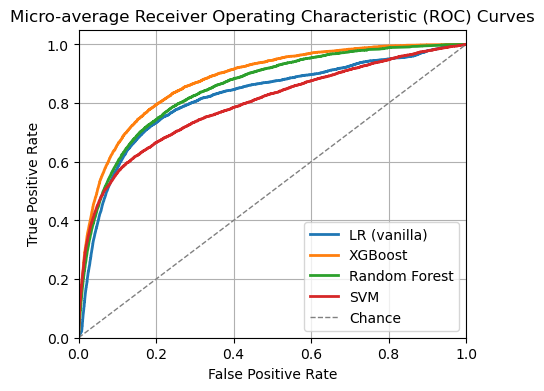

In [51]:
plt.figure(figsize=(5, 4))  # Adjust figure size as needed

# Plot ROC curve for Logistic Regression (vanilla)
plt.plot(fpr_lrvan, tpr_lrvan, lw=2, label=f'LR (vanilla)') #AUC = {micro_auc_lrvan:.2f}')

# Plot ROC curve for Logistic Regression (L1 penalty)
#plt.plot(fpr_lrl1, tpr_lrl1, lw=2, label=f'LR (L1) AUC = {micro_auc_lrl1:.2f}')

# Plot ROC curve for Logistic Regression (L2 penalty)
#plt.plot(fpr_lrl2, tpr_lrl2, lw=2, label=f'LR (L2) AUC = {micro_auc_lrl2:.2f}')

# Plot ROC curve for Logistic Regression (Elastic Net)
#plt.plot(fpr_lrel, tpr_lrel, lw=2, label=f'LR (Elastic Net) AUC = {micro_auc_lrel:.2f}')

# Plot ROC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost') #AUC = {micro_auc_xgb:.2f}')

# Plot ROC curve for Random Forest
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest') #AUC = {micro_auc_rf:.2f}')

# Plot ROC curve for SVM
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM') #AUC = {micro_auc_svm:.2f}')


# Plot the chance line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic (ROC) Curves')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [52]:
# Precision Recall Curve
p_lrvan, r_lrvan, _ = precision_recall_curve(y_test.ravel(),y_prpos_lrvan.ravel())
p_lrl1, r_lrl1, _ = precision_recall_curve(y_test.ravel(),y_prpos_lrl1.ravel())
p_lrl2, r_lrl2, _ = precision_recall_curve(y_test.ravel(),y_prpos_lrl2.ravel())
p_lrel, r_lrel, _ = precision_recall_curve(y_test.ravel(),y_prpos_lrel.ravel())
p_xgb, r_xgb, _ = precision_recall_curve(y_test.ravel(),y_prpos_xgb.ravel())
p_rf, r_rf, _ = precision_recall_curve(y_test.ravel(),y_prpos_rf.ravel())
p_svm, r_svm, _ = precision_recall_curve(y_test.ravel(),y_dec_svm.ravel())

In [53]:
# Get micro average precisions
micro_p_lrvan = average_precision_score(y_test, y_prpos_lrvan, average="micro")
micro_p_lrl1 = average_precision_score(y_test, y_prpos_lrl1, average="micro")
micro_p_lrl2 = average_precision_score(y_test, y_prpos_lrl2, average="micro")
micro_p_lrel = average_precision_score(y_test, y_prpos_lrel, average="micro")
micro_p_xgb = average_precision_score(y_test, y_prpos_xgb, average="micro")
micro_p_rf = average_precision_score(y_test, y_prpos_rf, average="micro")
micro_p_svm = average_precision_score(y_test, y_dec_svm, average="micro")

print("LR vanilla", micro_p_lrvan, "LR L1", micro_p_lrl1, "LR L2", micro_p_lrl2, "LR elastic", micro_p_lrel, 
      "XGB", micro_p_xgb, "RF", micro_p_rf, "SVM", micro_p_svm)

LR vanilla 0.2050686227280707 LR L1 0.3496284342193354 LR L2 0.3692843891652095 LR elastic 0.36389447428993843 XGB 0.34574668762817073 RF 0.28870397187596064 SVM 0.3025036634521578


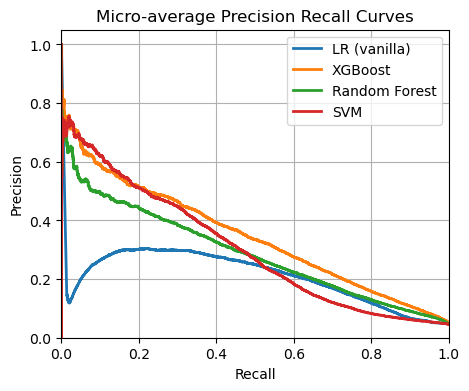

In [54]:
plt.figure(figsize=(5, 4))  # Adjust figure size as needed

# Plot ROC curve for Logistic Regression (vanilla)
plt.plot(r_lrvan, p_lrvan, lw=2, label=f'LR (vanilla)') #avg prec = {micro_p_lrvan:.2f}')

# Plot ROC curve for Logistic Regression (L1 penalty)
#plt.plot(r_lrl1, p_lrl1, lw=2, label=f'LR (L1) avg prec = {micro_p_lrl1:.2f}')

# Plot ROC curve for Logistic Regression (L2 penalty)
#plt.plot(r_lrl2, p_lrl2, lw=2, label=f'LR (L2) avg prec = {micro_p_lrl2:.2f}')

# Plot ROC curve for Logistic Regression (Elastic Net)
#plt.plot(r_lrel, p_lrel, lw=2, label=f'LR (Elastic Net) avg prec = {micro_p_lrel:.2f}')

# Plot ROC curve for XGBoost
plt.plot(r_xgb, p_xgb, lw=2, label=f'XGBoost') #avg prec = {micro_p_xgb:.2f}')

# Plot ROC curve for Random Forest
plt.plot(r_rf, p_rf, lw=2, label=f'Random Forest') #avg prec = {micro_p_rf:.2f}')

# Plot ROC curve for SVM
plt.plot(r_svm, p_svm, lw=2, label=f'SVM') #avg prec = {micro_p_svm:.2f}')


# Plot the chance line
#plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')

# Add labels, title, and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-average Precision Recall Curves')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='upper right')
plt.grid(True)
plt.show()